# Estimate deadtime by using data taken in the surface

#

### Import needed libraries

In [1]:
#import ROOT

import sys
import math

import numpy as np
#from ROOT import TH1D,TF1, gRandom, gPad, gStyle, TCanvas
import matplotlib as mpl
import matplotlib.pyplot as plt
#from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.colors as colors
from scipy.optimize import curve_fit
import scipy.signal
from lmfit.models import GaussianModel, ConstantModel
from datetime import datetime
from glob import glob
import pylandau

In [2]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
# mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
#warnings.filterwarnings("ignore")

### Import parser that Tom wrote. This is containted in the file named $\texttt{dt5202.py}$ in this folder

In [3]:
from dt5202 import dt5202_crunch

from dt5202oldDAQ import dt5202_crunch as dt5202_crunch_oldDAQ
ped = 50 #pedestal correction

In [37]:
#Import data files
#sourceFolder = "/data/20220826_AND48hrs#/1
sourceFolder ="/Users/irisponce/Documents/RHI/lfHCal/Micro30035-2_28p8V_Gain50_5p0Amp/"
#sourceFolder = "/Users/irisponce/Documents/RHI/lfHCal/3TileCoincidence_Micro30035_28p8V_Gain50_purpleStand/"
folder_name = os.getcwd() # could use this if analysis code is in the same directory as data
#loading all files in this directory
onlyfiles = [f for f in os.listdir(sourceFolder) if '.dat' in f]
print(onlyfiles)
data_list = []
for file in onlyfiles:
    
    data_list.append(dt5202_crunch(str(sourceFolder)+str(file), num_ev=10000000, num_ch=1))

data = data_list[0]

for i in range(1, len(data_list)):
    data = np.append(data, data_list[i])

#f = sourceFolder+'Run0_list.dat'
#data = dt5202_crunch(f, num_ev=10000000, num_ch=2)

['Run1_list.dat']
[(259, [3, 1, 0], 1, 0, 288, 0.5, 1691786015989)]
((33, 0, 1.69178602e+09, 0, 8), (3, 3, 169, 1842))


/Users/irisponce/Documents/RHI/dt5202.py:37: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  dt = np.dtype([('header',eh_dt), ('data',ch_dt,num_ch)])


In [5]:
print (data[0])
print (data[1])
#print (data[2])
#print (data[3])

#print (data[4])
#print (data[64])


# print (data['data']['low_gain'][:,0])
# print (data['data']['high_gain'][0])
# print (data['data']['low_gain'][3])
# print (data['data']['high_gain'][3])
# print (data['data']['low_gain'][5])
# print (data['data']['high_gain'][5])
#print (data['channel_id']['data']['high_gain'][0])

((45, 0, 1.69244271e+09, 0, 8589934602), [( 1, 3, 2693, 7981), ( 3, 3, 2292, 7940), (33, 3, 1983, 7980)])
((45, 0, 1.69244271e+09, 1, 8589934602), [( 1, 3, 1434, 7981), ( 3, 3, 1283, 7940), (33, 3, 1443, 7980)])


In [4]:
#data.shape
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

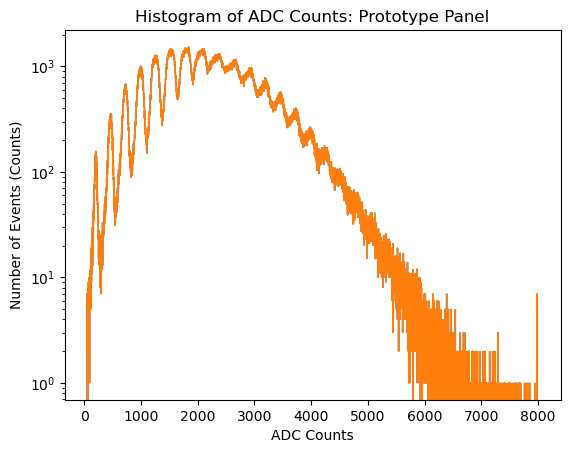

In [20]:
#plotting High Gain Data to View SPE peaks
plt.hist(data['data']['high_gain'],bins=7950 ,range=(50,8001),
         histtype='step');
#plt.xlim(3200,4500)
# plt.ylim(0,1000)
plt.yscale('log')




plt.xlabel('ADC Counts')
plt.ylabel('Number of Events (Counts)')
plt.title('Histogram of ADC Counts: Prototype Panel')
plt.show()
# Can work on naming scheme
#plt.savefig(sourceFolder + '/' + 'ADCHist_HighGain_7950Bins.png')

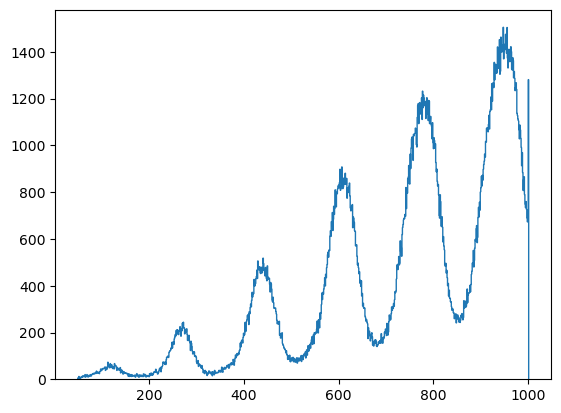

In [27]:
plt.hist(data['data']['high_gain'],bins=950 ,range=(50,1001),
         histtype='step');

In [5]:
def gauss(x, mu, sigma):
    return 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2/(2*sigma**2))


def sps(x, ped = 50, gain = 50, width_base = 5, width_scale = 1, poisson_k = 5, output_single_peaks = False):

    out = np.zeros_like(x)

    out_peaks = []

    for n_pe in np.arange(0, int((3*poisson_k)+5), 1):
        
        A = scipy.stats.poisson.pmf(n_pe, poisson_k)
        mu = ped + gain * n_pe
        sigma = np.sqrt(width_base**2 +  width_scale**2 * n_pe)

        peak = A * gauss(x, mu, sigma)
        
        out += peak
        out_peaks.append(peak)

    if output_single_peaks:
        return np.array(out), np.array(out_peaks)
    else:
        return np.array(out)

def sps_freeamp_fit(x, ped = 50, gain = 50, width_base = 5, width_scale = 1, ped_offs = 0, *ampls):

    out = np.zeros_like(x)

    for i, ampl in enumerate(ampls):
        mu = ped + gain * i
        if i>0:
            mu += ped_offs
            
        sigma = np.sqrt(width_base**2 +  width_scale**2 * i)

        peak = ampl * gauss(x, mu, sigma)
        
        out += peak
        
    return np.array(out)
    
def sps_freeamp(x, ped = 50, gain = 50, width_base = 5, width_scale = 1, ped_offs = 0, *ampls, output_single_peaks = False):

    out = np.zeros_like(x)
    out_peaks = []
    #mus=[]

    for i, ampl in enumerate(ampls):
        mu = ped + gain * i
        if i>0:
            mu += ped_offs
            
        sigma = np.sqrt(width_base**2 +  width_scale**2 * i)

        peak = ampl * gauss(x, mu, sigma)
        
        out += peak
        out_peaks.append(peak)
        #mus.append(mu)
        #print (mu,sigma)
    if output_single_peaks:
        return np.array(out), np.array(out_peaks)
    else:
        return np.array(out)

def sps_freeampMus(x, ped = 50, gain = 50, width_base = 5, width_scale = 1, ped_offs = 0, *ampls):

    out = np.zeros_like(x)
    out_peaks = []
    mus=[]

    for i, ampl in enumerate(ampls):
        mu = ped + gain * i
        if i>0:
            mu += ped_offs
            
        sigma = np.sqrt(width_base**2 +  width_scale**2 * i)

        peak = ampl * gauss(x, mu, sigma)
        
        out += peak
        out_peaks.append(peak)
        mus.append(mu)
    return mus

def poisson_ampls(poisson_k):
    r = np.array([scipy.stats.poisson.pmf(n_pe, poisson_k) for n_pe in np.arange(0, int((3*poisson_k)+5), 1)])
    print(r)
    return r

In [7]:
_ = plt.hist(data['data']['high_gain'],bins=7950 ,range=(50,8001),
         histtype='step', density  = True)

x = np.linspace(0,8001, 10000)
#multigauss, peaks =  sps(x, ped = 30, gain = 175, poisson_k = 7.5, width_base = 15, width_scale=15, output_single_peaks=True)
multigauss, peaks =  sps(x, ped = 0, gain =70, poisson_k = 5.5, width_base = 10, width_scale=10, output_single_peaks=True)


plt.plot(x, multigauss)
for peak in peaks:
    plt.plot(x, peak, '--', color = 'C1')
    
plt.xlim(0,4000)

(0.0, 4000.0)

In [18]:
data1=(int((data['data']['channel_id'][:,0]))

print (type(data1[0]))
print ((data1[1]))

<class 'numpy.int8'>
0


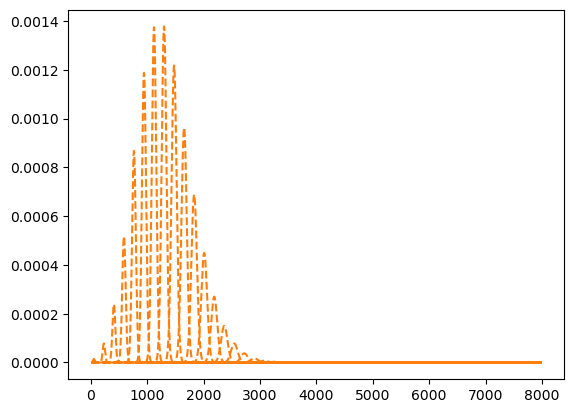

In [49]:
for peak in peaks:
    plt.plot(x, peak, '--', color = 'C1')

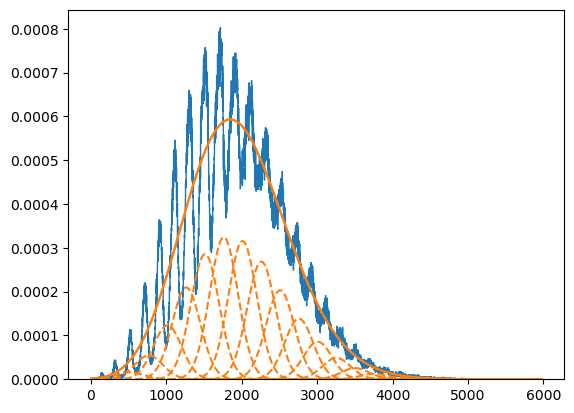

<Figure size 640x480 with 0 Axes>

[1.10176633e-003 7.50395492e-003 2.55541205e-002 5.80150141e-002
 9.87827537e-002 1.34558718e-001 1.52742998e-001 1.48615459e-001
 1.26524526e-001 9.57487091e-002 6.52129198e-002 4.03777094e-002
 2.29171787e-002 1.20065578e-002 5.84105369e-003 2.65216572e-003
 1.12896738e-003 4.52306875e-004 1.71143891e-004 6.13491457e-005
 2.08919627e-005 6.77580135e-006 2.09767741e-006 6.21171589e-007
 1.76279196e-007 4.80243803e-008 1.25802462e-008 3.17340933e-009
 7.71913756e-010 1.81289020e-010 4.11576874e-011 9.04253062e-012
 1.92460109e-012 3.97216706e-013 7.95699906e-014 1.54839579e-014
 2.92941026e-015 5.39236389e-016 9.66487660e-017 1.68784447e-017
 2.87390992e-018 4.77408352e-019 7.74179095e-020 1.22623498e-020
 1.89811160e-021 2.87283014e-022 4.25356265e-023 6.16390156e-024
 8.74611483e-025 1.21568151e-025 1.65596261e-026 2.21147008e-027
 2.89653275e-028 3.72223074e-029 4.69472599e-030 5.81364191e-031
 7.07067652e-032 8.44864052e-033 9.92109381e-034 1.14527100e-034
 1.30004304e-035 1.451538

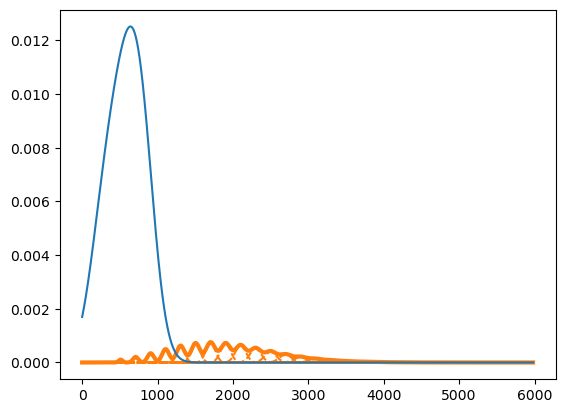

No handles with labels found to put in legend.


[ 5.10904507e+002  1.98660515e+002  2.55407458e+001  2.29393689e+001
  4.08439872e-007  6.76310192e-003  1.76568394e-002  3.55808053e-002
  5.87519139e-002  8.23551367e-002  1.03502889e-001  1.15843628e-001
  1.17576327e-001  1.11001193e-001  9.63272766e-002  7.72946778e-002
  5.85839357e-002  4.16673537e-002  2.81404955e-002  1.78384052e-002
  1.10959574e-002  6.40801816e-003  3.52541006e-003  1.99320690e-003
  1.02806600e-003  5.63555201e-004  2.30271961e-004  1.32641641e-004
  2.37826487e-005  4.35895746e-005 -3.18086121e-006  6.67862141e-006
 -2.38030634e-006  2.47874090e-005 -7.88294994e-004  8.20946255e-002
  9.04253062e-012  1.92460109e-012  3.97216706e-013  7.95699906e-014
  1.54839579e-014  2.92941026e-015  5.39236389e-016  9.66487660e-017
  1.68784447e-017  2.87390992e-018  4.77408352e-019  7.74179095e-020
  1.22623498e-020  1.89811160e-021  2.87283014e-022  4.25356265e-023
  6.16390156e-024  8.74611483e-025  1.21568151e-025  1.65596261e-026
  2.21147008e-027  2.89653275e-028

In [15]:
#content, bins, _ = plt.hist(data['data']['high_gain'],bins=7950 ,range=(50,8001),
         #histtype='step', density  = True)
#centers = (bins[:-1] + bins[1:])/2
content, bins, _ = plt.hist(data['data']['high_gain'],bins=np.max(data['data']['high_gain'])
                            ,range=(0,np.max(data['data']['high_gain']+1)),
         histtype='step', density  = True)
centers = (bins[:-1] + bins[1:])/2
x = np.linspace(0,np.max(data['data']['high_gain']), len(content))

def fitfunc(x, ped, gain, poisson_k):
    return sps(x, ped, gain, poisson_k, 8, 10)
r, cov = scipy.optimize.curve_fit(sps, centers, content, p0 = [0, 70, 15, 15, 5.5])
#r, cov = scipy.optimize.curve_fit(fitfunc, centers, content, p0 = [75, 42, 2.3])

multigauss, peaks =  sps(x, *r, output_single_peaks=True)

plt.plot(x, multigauss, color='C1')
for peak in peaks:
    plt.plot(x, peak, '--', color = 'C1')
plt.plot(x, sps(x, *r))

plt.figure()
plt.show()


#content, bins, _ = plt.hist(data['data']['high_gain'],bins=7950 ,range=(50,8001),
 #        histtype='step', density  = True)


r2, cov2 = scipy.optimize.curve_fit(sps_freeamp_fit, centers, content, p0 = [*r[:-1], 0, *poisson_ampls(r[-1])])


multigauss, peaks =  sps_freeamp(x, *r2, output_single_peaks=True)

plt.plot(x, multigauss, color='C1', label = f'Multi-Gauss Fit, gain = {r2[1]:.2f} ADC/p.e.', lw = 3)
for peak in peaks:
    plt.plot(x, peak, '--', color = 'C1')
plt.plot(x, sps_freeamp(x, *r[:-1], 1, 2, 3, 4))
plt.show()
print(r2)

#plt.legend()

plt.xlim(0, 4500)
#plt.ylim(0, 0.002)

plt.xlabel('Signal Amplitude in ADC')
plt.ylabel('Normalized Counts')

plt.legend(fontsize = 'x-large')

8001


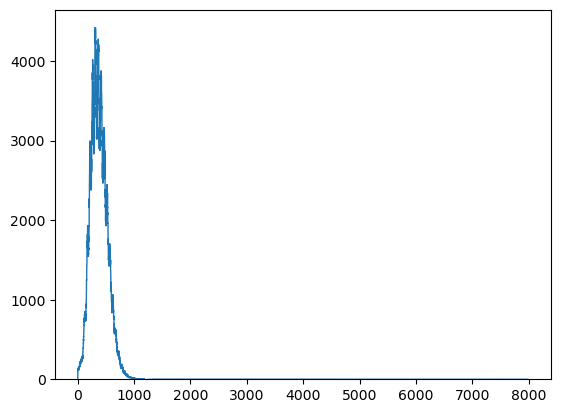

In [116]:
from scipy.interpolate import splrep, BSpline
content, bins, _ = plt.hist(data['data']['high_gain'],bins=8001,range=(0,8001),
         histtype='step', density  = False)
centers = (bins[:-1] + bins[1:])/2
print (len(centers))
#tck = splrep(centers, content, s=0)
#tck_s = splrep(centers, content, s=100)
#xnew = np.arange(0, 201)
#plt.plot(xnew, np.sin(xnew), '-.', label='sin(x)')
#plt.plot(xnew, BSpline(*tck)(xnew), '-', label='s=0')
#plt.plot(xnew, BSpline(*tck_s)(xnew), '-', label=f's={len(centers)}')
#s = scipy.interpolate.InterpolatedUnivariateSpline(xnew, BSpline(*tck)(xnew))
#ynew = s(xnew)
#plt.plot( xnew, ynew)
#plt.plot(centers, content, 'o')
#plt.legend()
#plt.xscale("log")
#plt.yscale("log")
#plt.show()

In [38]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    import numpy as np
    from math import factorial
    

    window_size = np.abs(np.int(window_size))
    order = np.abs(np.int(order))
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

6535
-142


/var/folders/y_/_l_p6x6n7y59yrfw8sb35m9m0000gn/T/ipykernel_8448/3954097150.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  window_size = np.abs(np.int(window_size))
/var/folders/y_/_l_p6x6n7y59yrfw8sb35m9m0000gn/T/ipykernel_8448/3954097150.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your c

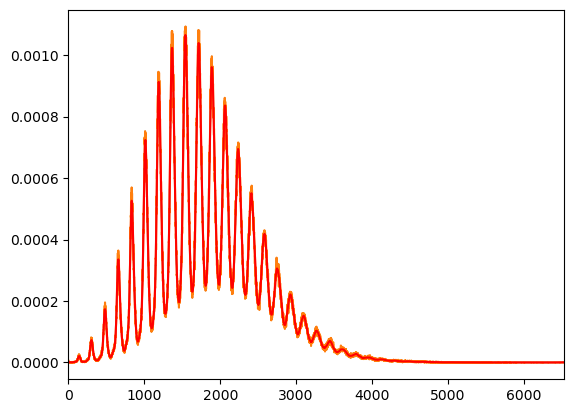

In [39]:
content, bins, _ = plt.hist(data['data']['high_gain'],bins=np.max(data['data']['high_gain'])
                            ,range=(0,np.max(data['data']['high_gain']+1)),
         histtype='step', density  = True)

centers = (bins[:-1] + bins[1:])/2

print (np.max(data['data']['high_gain']))
print (np.min(data['data']['high_gain']))

yhat = savitzky_golay(content, 51, 3)
plt.plot(centers,content)
plt.plot(centers,yhat, color='red')
plt.xlim(0,np.max(data['data']['high_gain']))
plt.show()
#plt.yscale("log")

In [40]:
plt.figure(figsize=(8,4))


peaks_in_interval = scipy.signal.find_peaks_cwt(yhat, widths=10)
number_of_peaks = len(peaks_in_interval)
amplitude = yhat[peaks_in_interval]
width = np.zeros(number_of_peaks) + 10
center = centers[peaks_in_interval]

print (peaks_in_interval)

peak_dist = np.diff(peaks_in_interval)
print (peak_dist)
print (np.median(peak_dist))
print (np.median(data['data']['high_gain']))
print (np.median(data['data']['high_gain'])/np.median(peak_dist))



#plt.plot(centers,yhat)
#plt.xlim(0,1000)

[ 140  302  481  656  831 1011 1187 1362 1538 1713 1886 2059 2233 2408
 2582 2742 2923 3100 3266 3448 3588 3794 3975 4105 4288 4500 4651 5145
 5304 5346 5474 5665 5822 5895 6005 6171 6249 6318 6412 6473 6531]
[162 179 175 175 180 176 175 176 175 173 173 174 175 174 160 181 177 166
 182 140 206 181 130 183 212 151 494 159  42 128 191 157  73 110 166  78
  69  94  61  58]
173.5
1805.0
10.403458213256485


first fit covariance [[ 3.68095198e-01 -3.65027605e-02  2.16138471e-03 -1.47775898e-03
   5.35053904e-04]
 [-3.65027605e-02  3.93336073e-03  9.31175893e-04 -3.75516593e-05
  -6.91120764e-05]
 [ 2.16138471e-03  9.31175893e-04  6.19090885e-01 -1.10580989e-01
  -2.27268598e-04]
 [-1.47775898e-03 -3.75516593e-05 -1.10580989e-01  2.14438737e-02
   3.96603653e-05]
 [ 5.35053904e-04 -6.91120764e-05 -2.27268598e-04  3.96603653e-05
   1.30146507e-04]]
[2.13880847e-05 2.29979157e-04 1.23644575e-03 4.43170042e-03
 1.19131603e-02 2.56196720e-02 4.59133412e-02 7.05273298e-02
 9.47946960e-02 1.13255190e-01 1.21779643e-01 1.19041556e-01
 1.06667946e-01 8.82281477e-02 6.77634813e-02 4.85759199e-02
 3.26450722e-02 2.06483473e-02 1.23347222e-02 6.98059363e-03
 3.75300328e-03 1.92165859e-03 9.39226062e-04 4.39095395e-04
 1.96727115e-04 8.46137219e-05 3.49932302e-05 1.39359588e-05
 5.35174491e-06 1.98433042e-06 7.11228775e-07 2.46697193e-07
 8.28954729e-08 2.70105518e-08 8.54222729e-09 2.62433735e-09
 7.8

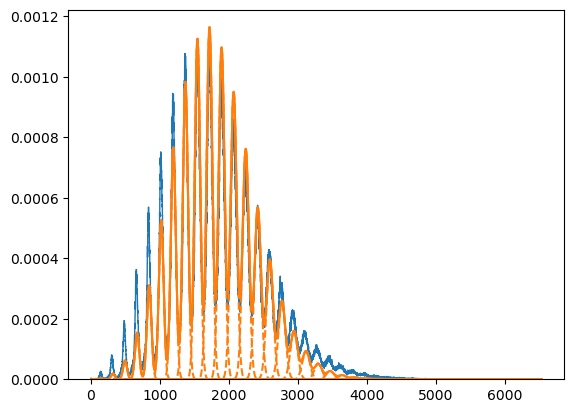

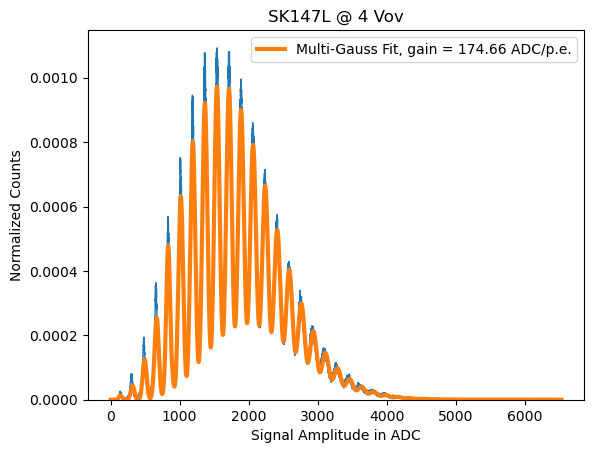

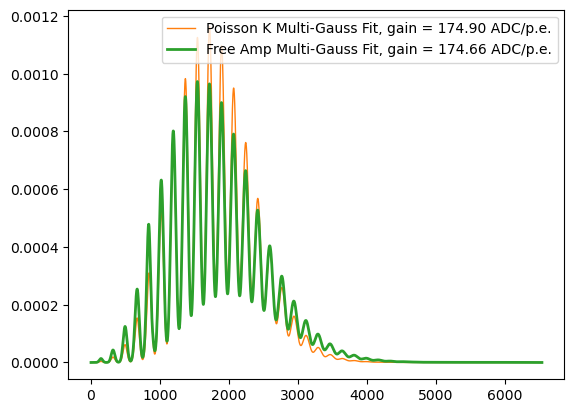

In [51]:
content, bins, _ = plt.hist(data['data']['high_gain'],bins=np.max(data['data']['high_gain'])
                            ,range=(0,np.max(data['data']['high_gain'])),
         histtype='step', density  = True)

centers = (bins[:-1] + bins[1:])/2

x = np.linspace(0,np.max(data['data']['high_gain']), len(content))


def fitfunc(x, ped, gain, poisson_k):
    return sps(x, ped, gain, poisson_k, 8, 10)
r, cov = scipy.optimize.curve_fit(sps, centers, content, p0 = [0, np.median(peak_dist), 15, 15, np.median(data['data']['high_gain'])/np.median(peak_dist)],sigma=np.where(content>0, np.sqrt(content), 1))
#r, cov = scipy.optimize.curve_fit(sps, centers, content, p0 = [0, 140, 5, 5, np.median(data['data']['high_gain'])/np.median(peak_dist)])

#r, cov = scipy.optimize.curve_fit(fitfunc, centers, content, p0 = [75, 42, 2.3])

multigauss, peaks =  sps(x, *r, output_single_peaks=True)
print ("first fit covariance",cov)
plt.plot(x, multigauss, color='C1')
for peak in peaks:
    plt.plot(x, peak, '--', color = 'C1')
plt.plot(x, sps(x, *r))

plt.figure()


content, bins, _ = plt.hist(data['data']['high_gain'],bins=np.max(data['data']['high_gain'])
                            ,range=(0,np.max(data['data']['high_gain'])),
         histtype='step', density  = True)

centers = (bins[:-1] + bins[1:])/2


r2, cov2 = scipy.optimize.curve_fit(sps_freeamp_fit, centers, content, p0 = [*r[:-1], 0, *poisson_ampls(r[-1])],sigma=np.where(content>0, np.sqrt(content), 1))
perr = np.sqrt(np.diag(cov2))
print (perr,cov2)
mus=[]
multigauss1, peaks1 =  sps_freeamp(x, *r2, output_single_peaks=True)

plt.plot(x, multigauss1, color='C1', label = f'Multi-Gauss Fit, gain = {r2[1]:.2f} ADC/p.e.', lw = 3)
#for peak in peaks1:
#    plt.plot(x, peak, '--', color = 'C1')
#plt.plot(x, sps_freeamp(x, *r[:-1], 1, 2, 3, 4))

print(r2[1])

plt.legend()

#plt.xlim(0, 4500)
#plt.ylim(0, 0.002)

plt.xlabel('Signal Amplitude in ADC')
plt.ylabel('Normalized Counts')
plt.title("SK147L @ 4 Vov")
plt.legend(loc='best')
plt.show()

plt.plot(x, multigauss, color='C1', label = f'Poisson K Multi-Gauss Fit, gain = {r[1]:.2f} ADC/p.e.', lw =1)
plt.plot(x, multigauss1, color='C2', label = f'Free Amp Multi-Gauss Fit, gain = {r2[1]:.2f} ADC/p.e.', lw = 2)
plt.legend()
plt.show()
#print (yhat)


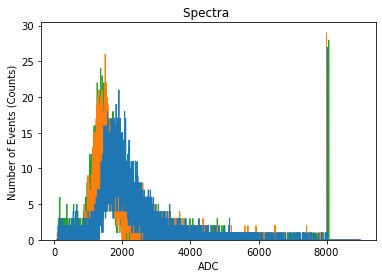

<Figure size 432x288 with 0 Axes>

In [71]:
#plotting High Gain Data to View SPE peaks
plt.hist(data['data']['low_gain'], bins=8950, range=(50,9000),
         histtype='step');
#plt.xlim(3200,4500)
# plt.ylim(0,1000)
#plt.yscale('log')

plt.xlabel('ADC')
plt.ylabel('Number of Events (Counts)')
plt.title('Spectra ')
plt.show()
# Can work on naming scheme
plt.savefig(sourceFolder + '/' + 'ADCHist_lowGainData.png')

1919.0


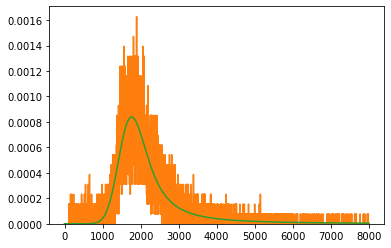

1763.7441656693263 [1.11028782e+01 3.63606381e+00 5.96595436e+00 4.72287629e-06]


In [104]:
print (np.median(data['data']['low_gain'][:,0]))


content1, bins, _ = plt.hist(data['data']['low_gain'][:,0],bins=8000,range=(0,8001),
         histtype='step', density  = True)

centers1 = (bins[:-1] + bins[1:])/2
plt.plot(centers1,content1)



x = np.linspace(0,8000, len(content))
mpv=np.median(data['data']['low_gain'][:,0])
eta=100
sigma=200
A=np.max(content1)
              
coeff, pcov = scipy.optimize.curve_fit(pylandau.langau, centers1,content1, p0=(mpv, eta, sigma, A))
plt.plot(x, pylandau.langau(x, *coeff), "-")
plt.show()
print (coeff[0],np.sqrt(np.diag(pcov)))
#print (np.max(content1))

1619.0


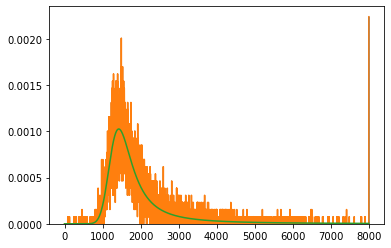

1424.8943556689053 [3.53826850e+01 2.60157275e+00 5.33892067e+00 5.61564448e-06]


In [97]:
print (np.median(data['data']['low_gain'][:,1]))


content1, bins, _ = plt.hist(data['data']['low_gain'][:,1],bins=8000,range=(0,8001),
         histtype='step', density  = True)

centers1 = (bins[:-1] + bins[1:])/2
plt.plot(centers1,content1)



x = np.linspace(0,8000, len(content))
mpv=np.median(data['data']['low_gain'][:,1])
eta=200
sigma=200
A=np.max(content1)
              
coeff, pcov = scipy.optimize.curve_fit(pylandau.langau, centers1,content1, p0=(mpv, eta, sigma, A))
plt.plot(x, pylandau.langau(x, *coeff), "-")
plt.show()
print (coeff[0],np.sqrt(np.diag(pcov)))
#print (np.max(content1))

1568.0


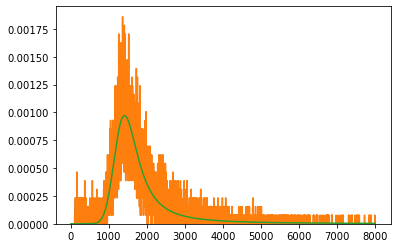

1408.9758837369654 [1.94888308e+01 2.85901145e+00 5.07350559e+00 5.44090083e-06]


In [98]:
print (np.median(data['data']['low_gain'][:,2]))


content1, bins, _ = plt.hist(data['data']['low_gain'][:,2],bins=8000,range=(0,8001),
         histtype='step', density  = True)

centers1 = (bins[:-1] + bins[1:])/2
plt.plot(centers1,content1)



x = np.linspace(0,8000, len(content))
mpv=np.median(data['data']['low_gain'][:,2])
eta=200
sigma=200
A=np.max(content1)
              
coeff, pcov = scipy.optimize.curve_fit(pylandau.langau, centers1,content1, p0=(mpv, eta, sigma, A))
plt.plot(x, pylandau.langau(x, *coeff), "-")
plt.show()
print (coeff[0],np.sqrt(np.diag(pcov)))
#print (np.max(content1))

99.72906976744187


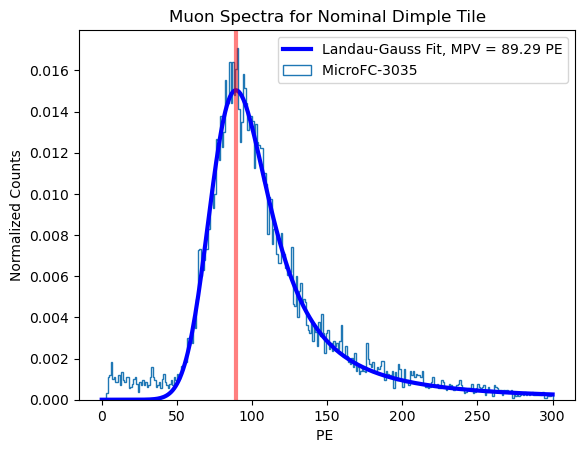

89.2861084455339 [2.38802414e-01 3.04185967e-01 5.39567645e-01 1.35479063e-04]


In [25]:
print (np.median(np.array(data['data']['low_gain'][:,2]-ped)*(11.3)*(1/172)))


content1, bins, _ = plt.hist(np.array(data['data']['low_gain'][:,2]-ped)*(11.3)*(1/172), bins=300,range=(0,300),
         histtype='step', density  = True,label="MicroFC-3035 ")

centers1 = (bins[:-1] + bins[1:])/2
#plt.plot(centers1,content1)



x = np.linspace(0,300, len(content1))
mpv=np.median(np.array(data['data']['low_gain'][:,2]-ped)*(11.3)*(1/172))
eta=5
sigma=5
A=np.max(content1)
              
coeff, pcov = scipy.optimize.curve_fit(pylandau.langau, centers1,content1, p0=(mpv, eta, sigma, A))
plt.plot(x, pylandau.langau(x, *coeff),color='b', label = f'Landau-Gauss Fit, MPV = {coeff[0]:.2f} PE', lw = 3)
plt.ylabel("Normalized Counts")
plt.xlabel("PE ")
plt.axvline(x = coeff[0], color = 'r',alpha=0.5,lw=3)

plt.legend()
plt.title('Muon Spectra for Nominal Dimple Tile')

plt.show()
print (coeff[0],np.sqrt(np.diag(pcov)))
#print (np.max(content1))

In [ ]:
content, bins, _ = plt.hist(data['data']['high_gain'],bins=np.max(data['data']['high_gain'])
                            ,range=(0,np.max(data['data']['high_gain']+1)),
         histtype='step', density  = True)

centers = (bins[:-1] + bins[1:])/2

x = np.linspace(0,np.max(data['data']['high_gain']), len(content))

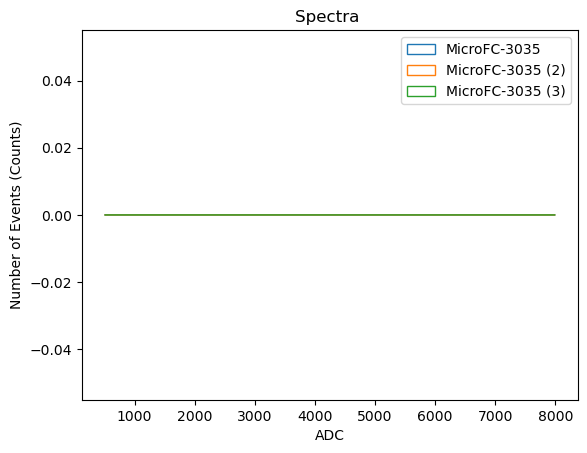

In [64]:
#plotting High Gain Data to View SPE peaks
plt.hist(np.array(data['data']['low_gain'][:,0]-ped)*(1/275), bins=1000, range=(500,8000),label="MicroFC-3035",
         histtype='step')
plt.hist(np.array(data['data']['low_gain'][:,1]-ped)*(1/278), bins=1000, range=(500,8000),label="MicroFC-3035 (2)",
         histtype='step')
plt.hist(np.array(data['data']['low_gain'][:,2]-ped)*(1/261), bins=1000, range=(500,8000),label="MicroFC-3035 (3)",
         histtype='step')
#plt.xlim(3200,4500)
# plt.ylim(0,1000)
#plt.yscale('log')
plt.legend()
plt.xlabel('ADC')
plt.ylabel('Number of Events (Counts)')
plt.title('Spectra ')
# Can work on naming scheme
plt.savefig(sourceFolder + '/' + 'ADCHist_lowGainData_SiPMsLabeled.png')
plt.show()

In [16]:
print (len(data['data']['low_gain'][:,0]))

12937


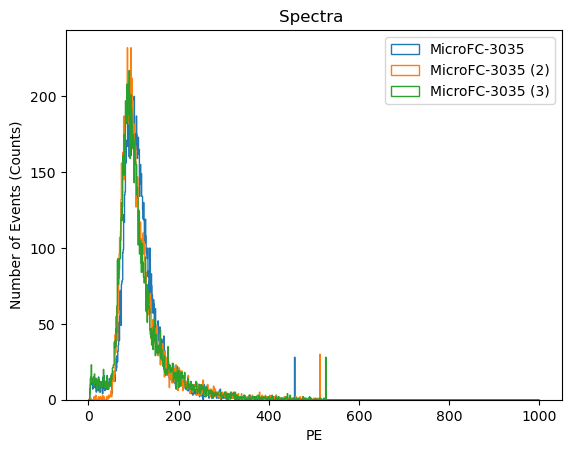

In [71]:
#plotting High Gain Data to View SPE peaks
plt.hist(np.array(data['data']['low_gain'][:,0]-ped)*(11.3)*(1/197), bins=1000,range=(0,1000),label="MicroFC-3035",
         histtype='step')
plt.hist(np.array(data['data']['low_gain'][:,1]-ped)*(11.3)*(1/175), bins=1000,range=(0,1000),label="MicroFC-3035 (2)",
         histtype='step')
plt.hist(np.array(data['data']['low_gain'][:,2]-ped)*(11.3)*(1/172), bins=1000,range=(0,1000),label="MicroFC-3035 (3)",
         histtype='step')
#plt.xlim(3200,4500)
# plt.ylim(0,1000)
#plt.yscale('log')
plt.legend()
plt.xlabel('PE')
plt.ylabel('Number of Events (Counts)')
plt.title('Spectra ')
# Can work on naming scheme
plt.savefig(sourceFolder + '/' + 'ADCHist_lowGainData_SiPMsLabeledINPE.png')
plt.show()


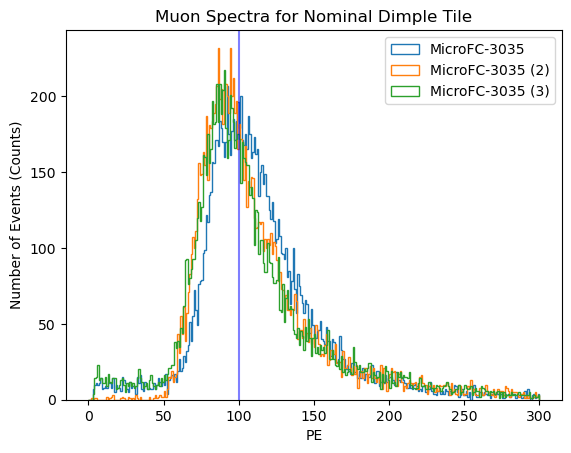

In [18]:
#plotting High Gain Data to View SPE peaks
plt.hist(np.array(data['data']['low_gain'][:,0]-ped)*(11.3)*(1/197), bins=300,range=(0,300),label="MicroFC-3035",
         histtype='step')
plt.hist(np.array(data['data']['low_gain'][:,1]-ped)*(11.3)*(1/175), bins=300,range=(0,300),label="MicroFC-3035 (2)",
         histtype='step')
plt.hist(np.array(data['data']['low_gain'][:,2]-ped)*(11.3)*(1/172), bins=300,range=(0,300),label="MicroFC-3035 (3)",
         histtype='step')
#plt.axvline(x = 50, color = 'b',alpha=0.5)
plt.axvline(x = 100, color = 'b',alpha=0.5)
#plt.axvline(x = 150, color = 'b',alpha=0.5)


#plt.xlim(3200,4500)
# plt.ylim(0,1000)
#plt.yscale('log')
plt.legend()
plt.xlabel('PE')
plt.ylabel('Number of Events (Counts)')
plt.title('Muon Spectra for Nominal Dimple Tile')
# Can work on naming scheme
plt.savefig(sourceFolder + '/' + 'ADCHist_lowGainData_SiPMsLabeledINPE_300PE.png')
plt.show()

In [ ]:

coeff, pcov = scipy.optimize.curve_fit(pylandau.langau, x, y, p0=(mpv, eta, sigma, A))

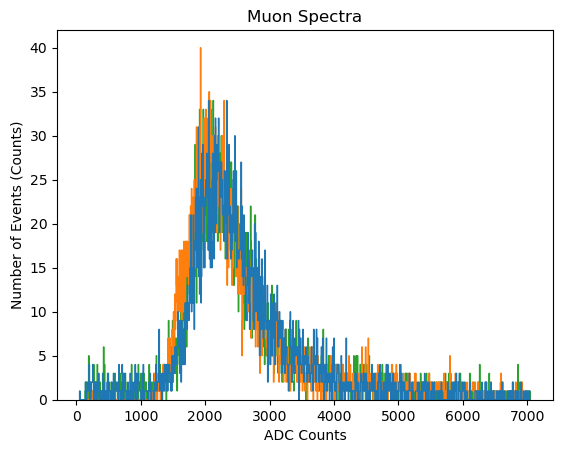

In [11]:
#plotting High Gain Data to View SPE peaks
plt.hist(data['data']['low_gain'],bins=1000 ,range=(50,7051),
         histtype='step');
#plt.xlim(3200,4500)
# plt.ylim(0,1000)
#plt.yscale('log')




plt.xlabel('ADC Counts')
plt.ylabel('Number of Events (Counts)')
plt.title('Muon Spectra')
# Can work on naming scheme
plt.savefig(sourceFolder + '/' + 'ADCHist_LowGain_7950Bins.png')

In [12]:
print (len(data['data']['low_gain'][:,0]))

4913


In [121]:
def make_model(num):
    pref = "f{0}_".format(num)
    model = GaussianModel(prefix = pref)
    model.set_param_hint(pref+'amplitude', value=amplitude[num], min=1, max=200*amplitude[num])
    model.set_param_hint(pref+'center', value=center[num], min=center[num]-10, max=center[num]+10)
    model.set_param_hint(pref+'sigma', value=width[num], min=1, max=50)
    return model

In [279]:
112-5

107

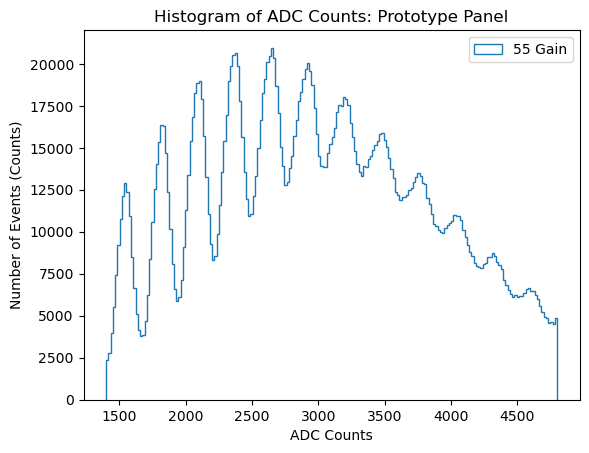

In [48]:
#plottig High Gain Data to View SPE peaks
Bin = 200
rangeMin =1400
rangeMax =4800
plt.hist(data['data']['high_gain']-ped, bins=Bin, range=(rangeMin,rangeMax),
         histtype='step',label="55 Gain");
#plt.xlim(3200,4500)
# plt.ylim(0,1000)
#plt.yscale('log')

plt.xlabel('ADC Counts')
plt.ylabel('Number of Events (Counts)')
plt.title('Histogram of ADC Counts: Prototype Panel')
plt.legend()

# Can work on naming scheme
plt.savefig(sourceFolder + '/' + 'ADCHist_HighGain_Bin'+str(Bin)+"range"+str(rangeMin)+str(rangeMax)+'.png')

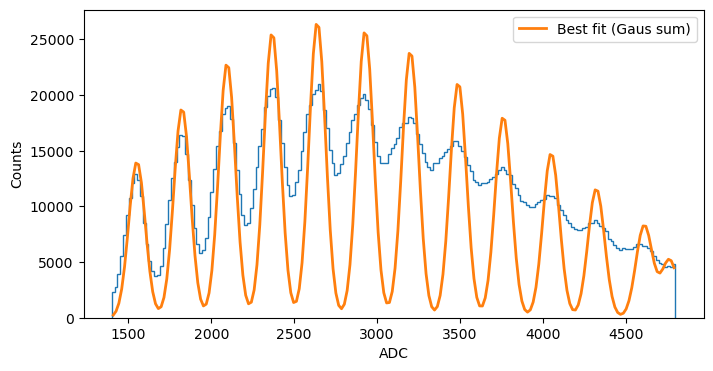

In [49]:
plt.figure(figsize=(8,4))

bin_heights, bin_borders, _ = plt.hist(np.array(data['data']['high_gain']-ped),  bins=Bin, range=(rangeMin,rangeMax),density=False, histtype='step');
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

peaks_in_interval = scipy.signal.find_peaks_cwt(bin_heights, widths=2)
number_of_peaks = len(peaks_in_interval)
amplitude = bin_heights[peaks_in_interval]
width = np.zeros(number_of_peaks) + 10
center = bin_centers[peaks_in_interval]

mod = None
for i in range(len(peaks_in_interval)):
    this_mod = make_model(i)
    if mod is None:
        mod = this_mod
    else:
        mod = mod + this_mod

offset = ConstantModel()
offset.set_param_hint('c', value=np.average(bin_heights))
mod = mod #+ offset

out=mod.fit(bin_heights, x=bin_centers)

plt.plot(bin_centers, out.best_fit, label='Best fit (Gaus sum)', lw = 2)
# plt.plot(bin_centers, out.init_fit, 'r--', label='fit with initial values')
plt.legend()
plt.xlabel("ADC")
plt.ylabel("Counts")
plt.savefig(sourceFolder + '/' + 'ADCHist_HighGain_Fit'+str(Bin)+"range"+str(rangeMin)+str(rangeMax)+'.png')

[3.53444995e-02 1.18142966e-01 1.97453077e-01 2.20003041e-01
 1.83846229e-01 1.22905341e-01 6.84708212e-02 3.26959176e-02
 1.36612228e-02 5.07379713e-03 1.69597377e-03 5.15362102e-04
 1.43554650e-04 3.69113514e-05 8.81288176e-06]
[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf]


/Users/irisponce/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


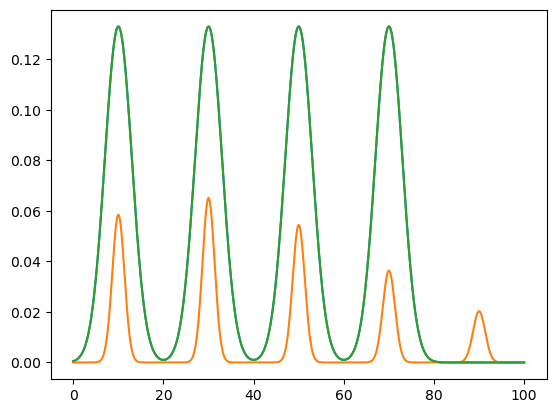

In [35]:
### try makign a multi gaussian spectra
x = np.linspace(0,100,1000)

gaus1= gauss(x,10,3)
gaus2=gauss(x,30,3)
gaus3=gauss(x,50,3)
gaus4=gauss(x,70,3)
#print(x)
#plt.plot(x,gaus1)
#plt.plot(x,gaus2)
#plt.plot(x,gaus3)
#plt.plot(x,gaus4)



#GausTry=[]
GausTry =gauss(x,10,3)
GausTry += gauss(x,30,3)
GausTry += gauss(x,50,3)
GausTry += gauss(x,70,3)


plt.plot(x,GausTry)



r,cov = scipy.optimize.curve_fit(sps,x,GausTry,p0=[0,20,5,5,5])
multigauss, peaks =  sps(x, *r, output_single_peaks=True)

plt.plot(x,multigauss)
#print(cov)


r2, cov2 = scipy.optimize.curve_fit(sps_freeamp_fit, x, GausTry, p0 = [*r[:-1], 0, *poisson_ampls(r[-1])])
perr = np.sqrt(np.diag(cov2))
print (perr)
mus=[]
multigauss1, peaks1 =  sps_freeamp(x, *r2, output_single_peaks=True)
plt.plot(x,multigauss1)
#r, cov = scipy.optimize.curve_fit(sps, centers, content, p0 = [0, np.median(peak_dist), 15, 15, np.median(data['data']['high_gain'])/np.median(peak_dist)],sigma=np.sqrt(content))

'''
content, bins, _ = plt.hist(gaus1,bins=1000,range=(0,100),histtype='step')
                       #     ,range=(0,np.max(data['data']['high_gain']+1)),
 #        histtype='step', density  = True)

centers = (bins[:-1] + bins[1:])/2

content2, bins2, _ = plt.hist(gaus2,bins=1000,range=(0,100),histtype='step')
content3, bins3, _ = plt.hist(gaus3,bins=1000,range=(0,100),histtype='step')
content4, bins4, _ = plt.hist(gaus4,bins=1000,range=(0,100),histtype='step')
totalGaus=content+content2+content3+content4
plt.plot(centers,totalGaus)
'''
#GaussFinal=np.unique(totalGaus)

#plt.plot(x,totalGaus)
#plt.plot(x,GaussFinal)
#plt.plot(x,gauss(x,30,3))
#plt.plot(x,gauss(x,40,3))
#plt.plot(x,gauss(x,50,3))

#bin_heights, bin_borders, _ = plt.his,bins=1000,range=(0,100),histtype='step')

plt.show()

In [41]:
#Import data files
#sourceFolder = "/data/20220826_AND48hrs#/"
sourceFolder2 = "/Users/irisponce/Documents/RHI/lfHCal/S4K33C0147L_60Gain_5P0Intensity_33P0V_SPE/"
folder_name = os.getcwd() # could use this if analysis code is in the same directory as data
#loading all files in this directory
onlyfiles2 = [f2 for f2 in os.listdir(sourceFolder2) if '.dat' in f2]
print(onlyfiles2)
data_list2 = []
for file2 in onlyfiles2:
    
    data_list2.append(dt5202_crunch(str(sourceFolder2)+str(file2), num_ev=10000000, num_ch=1))

data2 = data_list2[0]

for i in range(1, len(data_list2)):
    data2 = np.append(data2, data_list2[i])

['Run1_list.dat']
[(259, [3, 1, 0], 1, 0, 288, 0.5, 1689950556454)]
((33, 0, 1.68995056e+09, 0, 17179869184), (34, 3, 404, 3511))


In [82]:
#Import data files
#sourceFolder = "/data/20220826_AND48hrs#/"
sourceFolder3 = "/Users/irisponce/Documents/RHI/lfHCal/S4K33C0147L_57Gain_5P1Intensity_33P0V_SPE/"
folder_name = os.getcwd() # could use this if analysis code is in the same directory as data
#loading all files in this directory
onlyfiles3 = [f3 for f3 in os.listdir(sourceFolder3) if '.dat' in f3]
print(onlyfiles3)
data_list3 = []
for file3 in onlyfiles3:
    
    data_list3.append(dt5202_crunch(str(sourceFolder3)+str(file3), num_ev=10000000, num_ch=1))

data3 = data_list3[0]

for i in range(1, len(data_list3)):
    data3 = np.append(data3, data_list3[i])

['Run1_list.dat']
[(259, [3, 1, 0], 1, 0, 288, 0.5, 1689970878634)]
((33, 0, 1.68997088e+09, 0, 17179869184), (34, 3, 336, 3225))


In [83]:
mean2 = np.median(data2['data']['high_gain'])
print (mean2)

mean1 = np.median(data['data']['high_gain'])
print (mean1)

mean3 = np.median(data3['data']['high_gain'])
print (mean3)


3950.0
1680.0
2687.0


Text(0.5, 1.0, 'Histogram of ADC Counts: Prototype Panel')

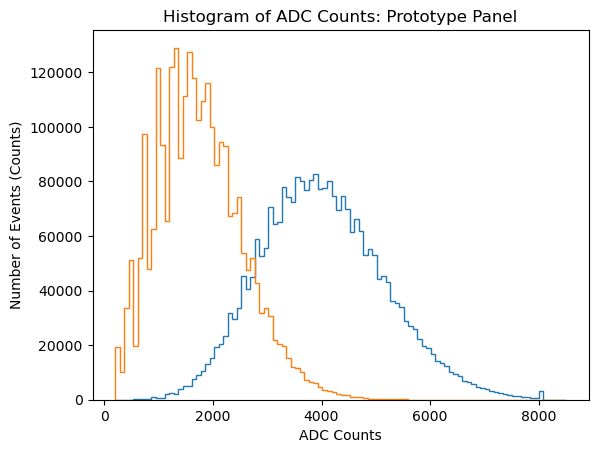

In [76]:
#plotting High Gain Data to View SPE peaks
Bin2 = 100 
rangeMin2 = 200
rangeMax2 =8500
plt.hist(data2['data']['high_gain'], bins=Bin2, range=(rangeMin2,rangeMax2),
         histtype='step',label="60 Gain");
#plt.xlim(3200,4500)
# plt.ylim(0,1000)
#plt.yscale('log')



#plotting High Gain Data to View SPE peaks
Bin = 100 
rangeMin = 200
rangeMax =8500
plt.hist(data['data']['high_gain'], bins=Bin, range=(rangeMin,rangeMax),
         histtype='step',label="61 Gain");
#plt.xlim(3200,4500)
# plt.ylim(0,1000)
#plt.yscale('log')

plt.xlabel('ADC Counts')
plt.ylabel('Number of Events (Counts)')
plt.title('Histogram of ADC Counts: Prototype Panel')
# Can work on naming scheme
#plt.savefig(sourceFolder + '/' + 'ADCHist_HighGain_'+str(Bin)+"range"+str(rangeMin)+str(rangeMax)+'.png')

In [85]:
mean2 = np.median(data2['data']['high_gain'])
print (mean2)

mean1 = np.median(data['data']['high_gain'])
print (mean1)

shift =(mean2-mean1)
print (shift)
shift2 = (mean3-mean1)

shiftedData = data['data']['high_gain'] - shift





3950.0
1680.0
2270.0


Text(0.5, 1.0, 'Histogram of ADC Counts: Prototype Panel')

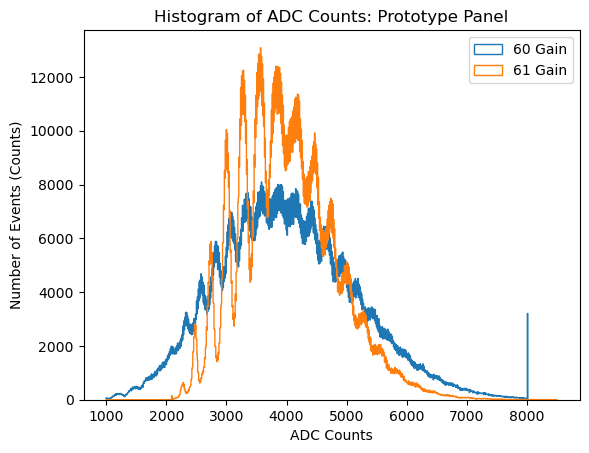

In [77]:
#plotting High Gain Data to View SPE peaks
Bin2 = 1000 
rangeMin2 = 1000
rangeMax2 =8500
plt.hist(data2['data']['high_gain'], bins=Bin2, range=(rangeMin2,rangeMax2),
         histtype='step',label="60 Gain");
#plt.xlim(3200,4500)
# plt.ylim(0,1000)
#plt.yscale('log')



#plotting0 High Gain Data to View SPE peaks
Bin = 1000
rangeMin = 1000
rangeMax =8500
plt.hist(data['data']['high_gain']+shift, bins=Bin, range=(rangeMin,rangeMax),
         histtype='step',label="61 Gain");
#plt.xlim(3200,4500)
# plt.ylim(0,1000)
#plt.yscale('log')
plt.legend()
plt.xlabel('ADC Counts')
plt.ylabel('Number of Events (Counts)')
plt.title('Histogram of ADC Counts: Prototype Panel')
# Can work on naming scheme
#plt.savefig(sourceFolder + '/' + 'ADCHist_HighGain_'+str(Bin)+"range"+str(rangeMin)+str(rangeMax)+'.png')

Text(0.5, 1.0, 'Single PE Spectra for Different HG AMP Gains')

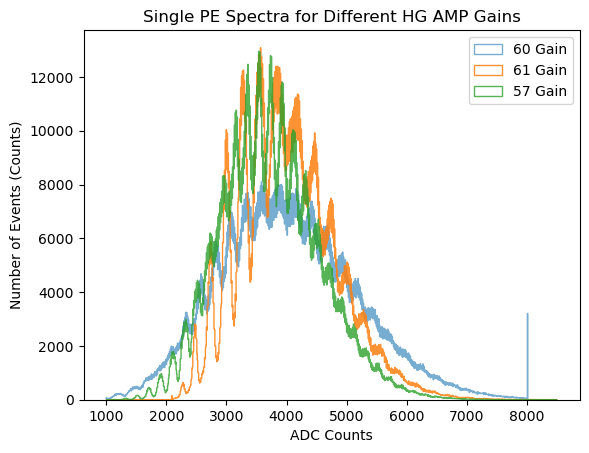

In [122]:
#plotting High Gain Data to View SPE peaks
Bin2 = 1000 
rangeMin2 = 1000
rangeMax2 =8500
plt.hist(data2['data']['high_gain'], bins=Bin2, range=(rangeMin2,rangeMax2),
         histtype='step',density=False,label="60 Gain",alpha=0.6);
#plt.xlim(3200,4500)
# plt.ylim(0,1000)
#plt.yscale('log')



#plotting0 High Gain Data to View SPE peaks
Bin = 1000
rangeMin = 1000
rangeMax =8500
plt.hist(data['data']['high_gain']+shift, bins=Bin, range=(rangeMin,rangeMax),
         histtype='step',density=False,label="61 Gain",alpha=0.85);
#plt.xlim(3200,4500)
# plt.ylim(0,1000)
#plt.yscale('log')


Bin3 = 1000
rangeMin3 = 1000
rangeMax3 =8500
plt.hist(data3['data']['high_gain']+shift2, bins=Bin3, range=(rangeMin3,rangeMax3),
         histtype='step',density=False,label="57 Gain",alpha=0.8);
plt.legend()
plt.xlabel('ADC Counts')
plt.ylabel('Number of Events (Counts)')
plt.title('Single PE Spectra for Different HG AMP Gains')
# Can work on naming scheme
#plt.savefig(sourceFolder + '/' + 'ADCHist_HighGain_'+str(Bin)+"range"+str(rangeMin)+str(rangeMax)+'.png')

In [67]:
def makeStaircasePlot(fname,Label,SiPM,Gain):
    import matplotlib as mpl
    mpl.rcParams.update(mpl.rcParamsDefault)
    staircase = np.loadtxt(fname)
    Legend=SiPM+" "+Gain + " " + Label
    plt.plot(staircase[:,0],staircase[:,1],label=Legend)
    plt.yscale("log")
    plt.legend()
    plt.xlabel("Threshold")
    plt.xlim(160,275)
    plt.ylabel("cps")
    plt.title("Staircase Plot")

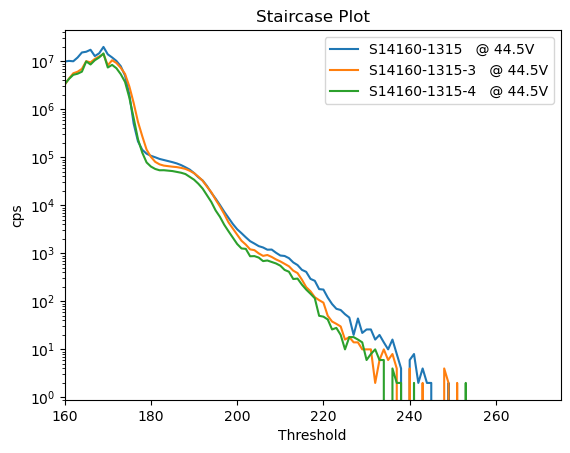

In [70]:
makeStaircasePlot("/Users/irisponce/Documents/RHI/lfHCal/S14160-1315_Group_57Gain_44P5V_Staircase/Run1_Staircase_0_1.txt","@ 44.5V","S14160-1315"," ")
makeStaircasePlot("/Users/irisponce/Documents/RHI/lfHCal/S14160-1315_Group_57Gain_44P5V_Staircase/Run1_Staircase_0_33.txt","@ 44.5V","S14160-1315-3"," ")
makeStaircasePlot("/Users/irisponce/Documents/RHI/lfHCal/S14160-1315_Group_57Gain_44P5V_Staircase/Run1_Staircase_0_35.txt","@ 44.5V","S14160-1315-4"," ")


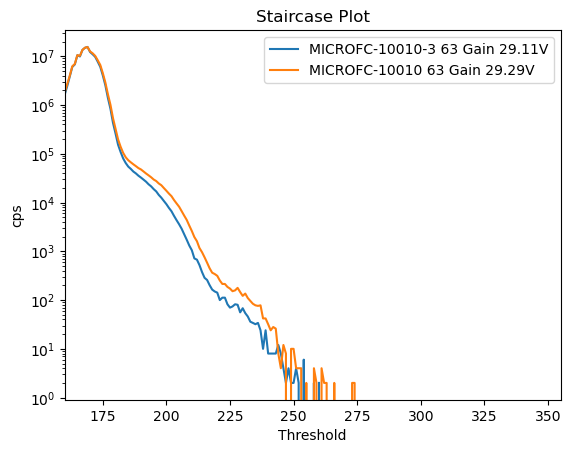

In [43]:
makeStaircasePlot("/Users/irisponce/Documents/RHI/lfHCal/Staircase_Characterization/MICROFC-10010-3(32)_63Gain_29P11V_Staircase/Run1_Staircase_0_32.txt","29.11V","MICROFC-10010-3","63 Gain")
makeStaircasePlot("/Users/irisponce/Documents/RHI/lfHCal/Staircase_Characterization/MICROFC-10010(32)_63Gain_29P29V_Staircase/Run1_Staircase_0_32.txt","29.29V","MICROFC-10010","63 Gain")



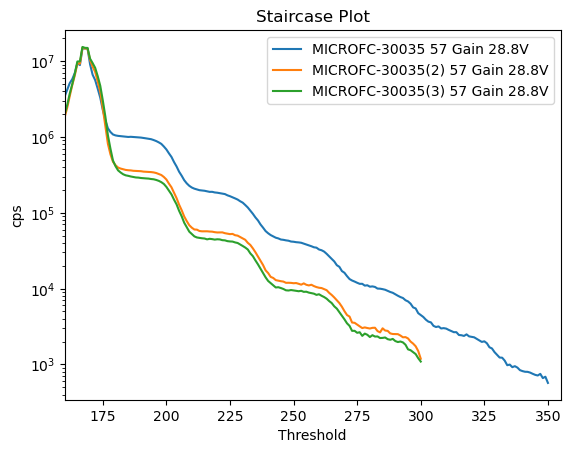

In [47]:
makeStaircasePlot("/Users/irisponce/Documents/RHI/lfHCal/Staircase_Characterization/MICROFC-3035(32)_57Gain_28P8V_Staircase_Fix_2/Run1_Staircase_0_32.txt","28.8V","MICROFC-30035","57 Gain")
makeStaircasePlot("/Users/irisponce/Documents/RHI/lfHCal/Staircase_Characterization/MICROFC-3035(32)_57Gain_28P8V_Staircase_Fix/Run1_Staircase_0_32.txt","28.8V","MICROFC-30035(2)","57 Gain")
makeStaircasePlot("/Users/irisponce/Documents/RHI/lfHCal/Staircase_Characterization/MICROFC-3035(32)_57Gain_28P8V_Staircase/Run1_Staircase_0_32.txt","28.8V","MICROFC-30035(3)","57 Gain")


In [14]:
#Now I want to work with the staircase plots

staircase1a = np.loadtxt("/Users/irisponce/Documents/RHI/lfHCal/Staircase_Characterization/S4K33C0147L2(32)_57Gain_32V_Staircase/Run1_Staircase_0_0.txt")
#staircase1b = np.loadtxt("/Users/irisponce/Documents/RHI/lfHCal/Staircase_Characterization/S4K33C0147L2(32)_57Gain_32V_Staircase/Run1_Staircase_0_32.txt")
#now we want to add the frequencies depending on their index
finalstaircase1 = staircase1a + staircase1b
#print (finalstaircase1[:, 0]/2)
#print (finalstaircase1[:,1])
plt.plot(finalstaircase1[:, 0]/2,finalstaircase1[:,1],label="32 V")

staircase2a = np.loadtxt("/Users/irisponce/Documents/RHI/lfHCal/Staircase_Characterization/S4K33C0147L2(32)_57Gain_33V_Staircase/Run1_Staircase_0_0.txt")
staircase2b = np.loadtxt("/Users/irisponce/Documents/RHI/lfHCal/Staircase_Characterization/S4K33C0147L2(32)_57Gain_33V_Staircase/Run1_Staircase_0_32.txt")
#now we want to add the frequencies depending on their index
finalstaircase2 = staircase2a + staircase2b
#print (finalstaircase1[:, 0]/2)
#print (finalstaircase1[:,1])
plt.plot(finalstaircase2[:, 0]/2,finalstaircase2[:,1],label="33 V")


staircase3a = np.loadtxt("/Users/irisponce/Documents/RHI/lfHCal/Staircase_Characterization/S4K33C0147L2(32)_57Gain_34V_Staircase/Run1_Staircase_0_0.txt")
staircase3b = np.loadtxt("/Users/irisponce/Documents/RHI/lfHCal/Staircase_Characterization/S4K33C0147L2(32)_57Gain_34V_Staircase/Run1_Staircase_0_32.txt")
#now we want to add the frequencies depending on their index
finalstaircase3 = staircase3a + staircase3b
#print (finalstaircase1[:, 0]/2)
#print (finalstaircase1[:,1])
plt.plot(finalstaircase3[:, 0]/2,finalstaircase3[:,1],label="34 V")
plt.title("S4K33C0147L2(32)_57Gain")
plt.yscale("log")
#plt.xscale("log")
plt.legend()
plt.xlabel("Threshold")
plt.xlim(finalstaircase3[0][0]/2,finalstaircase3[-1][0]/2)
plt.ylabel("cps")

NameError: name 'staircase1b' is not defined

160.0
350.0


## Now we can calculate the P.E./MeV by using the muon distribution from low gain data

#### A few technical details here: the Landau-Gaus fitting has to be done in ROOT, so I'll use ROOT here to do that. I'm first converting the numpy arrays into a TH1D object and then fitting.

In [34]:
from root_numpy import array2hist, hist2array, fill_hist
c1 = TCanvas( 'c1', 'Dynamic Filling Example', 200, 10, 700, 500 )
hpx = ROOT.TH1D( 'Gaussian-convoluted Landau', 'Background, no coincidences', 200, 0, 7500)
#fill_hist(hpx, np.array(data['data']['low_gain'][:,1]))
fill_hist(hpx, np.array(data['data']['low_gain']))

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: Gaussian-convoluted Landau (Potential memory leak).


/home/coure/Software/caenqdc_custom/scripts/PECollectionStudies
/home/coure/Iris_DT5202Analzer/dt5202_analysis
 FCN=83.5807 FROM MIGRAD    STATUS=CONVERGED    1386 CALLS        1387 TOTAL
                     EDM=1.73729e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  LandauWidth   3.10928e+02   8.16440e+00   3.60897e-02   4.09654e-06
   2  LandauMPV    2.67151e+03   8.75629e+00   5.48631e-02  -3.56714e-05
   3  Normalisation   1.27304e+03   1.13669e+02   9.13782e-02  -1.05479e-05
   4  GaussianSigma   2.51501e+02   2.23306e+01   1.82731e-02  -6.18236e-05
                               ERR DEF= 0.5


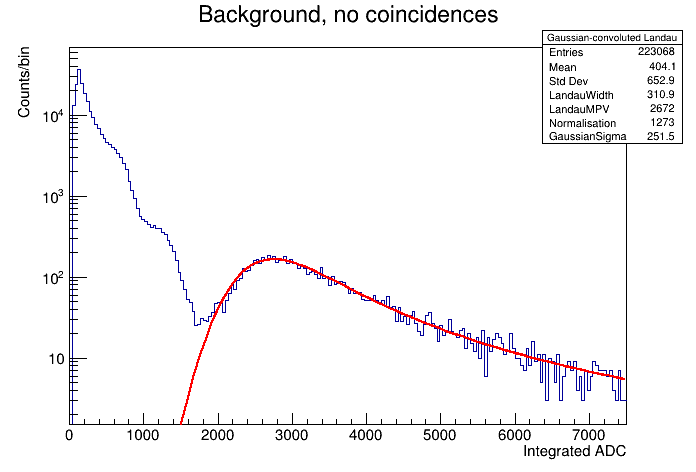

In [35]:
# Maybe it would be less confusing to include langaus in the same directory? I had trouble with this function because the file was not in the correct directory.
%cd /home/coure/Software/caenqdc_custom/scripts/PECollectionStudies
from langaus import LanGausFit
%cd - 

hpx.Draw()
gPad.SetLogy();
gStyle.SetOptFit(2)
fit = LanGausFit()
func = fit.fit(hpx, fitrange=(1900,8000))
# The fitter return a ROOT TF1 (a 1D function).
# func.Print()
hpx.GetXaxis().SetTitle("Integrated ADC");
hpx.GetYaxis().SetTitle("Counts/bin");

hpx.Draw()
func.Draw("same")
tf1 = ROOT.TF1("landaugausfunction", ROOT.langaufun, 0, 8000, 4)
tf1.SetParNames("LandauWidth","LandauMPV","Normalisation","GaussianSigma")
tf1.SetParameters(func.GetParameter(0), func.GetParameter(1), func.GetParameter(2), func.GetParameter(3))
tf1.Draw("same")

c1.Draw()
# c1.SaveAs("Fitted_noCoincidences_swirlyTry2.pdf");


In [37]:
func.GetChisquare()/func.GetNDF()

1.3212426091037126

In [38]:
MPV = func.GetParameter(1) #This corresponds to the most probable value (MPV) of the distr.
print(MPV)

2671.5065792573573


 FCN=232.548 FROM MIGRAD    STATUS=CONVERGED     116 CALLS         117 TOTAL
                     EDM=2.38352e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.52769e+03   2.56494e+01   5.32970e-02   2.33918e-05
   2  Mean         3.54883e+02   1.04723e+01   9.82376e-03   1.06892e-04
   3  Sigma        2.80845e+02   4.79518e+00   1.16054e-05   8.55302e-02
 FCN=88.0079 FROM MIGRAD    STATUS=CONVERGED      95 CALLS          96 TOTAL
                     EDM=5.99641e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.23008e+02   2.85218e+00   8.25077e-03   3.91332e-05
   2  Mean         1.06489e+03   1.60489e+01   1.94276e-02  -2.08457e-06
   3  Sigma        2.56686e+02   

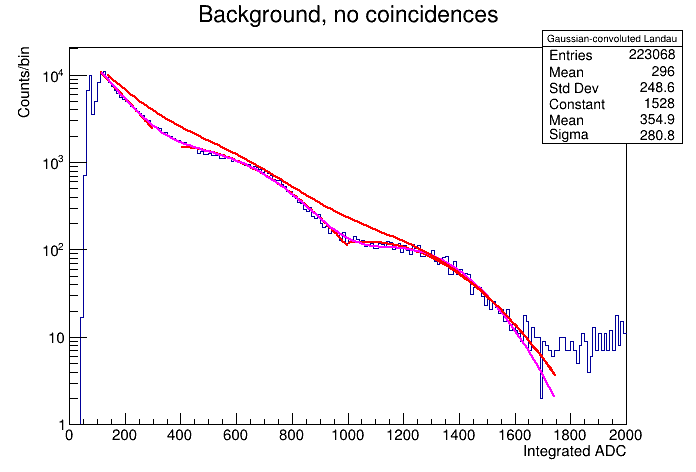

In [131]:
from array import array

c2 = TCanvas( 'c2', 'Dynamic Filling Example', 200, 10, 700, 500 )
hpx2 = ROOT.TH1D( 'Gaussian-convoluted Landau', 'Background, no coincidences', 200, 0, 2000)
#fill_hist(hpx, np.array(data['data']['low_gain'][:,1]))
fill_hist(hpx2, np.array(data['data']['low_gain']))

hpx2.Draw()
gPad.SetLogy();
gStyle.SetOptFit(2)
# fit = LanGausFit()
# func = fit.fit(hpx, fitrange=(0,4000))
# The fitter return a ROOT TF1 (a 1D function).
# func.Print()
hpx2.GetXaxis().SetTitle("Integrated ADC");
hpx2.GetYaxis().SetTitle("Counts/bin");

hpx2.Draw()

par = array( 'd', 9*[0.] )
g1 = TF1( 'g1', 'gaus',  400,  1000 )
g2 = TF1( 'g2', 'gaus',  1000, 1750 )
g3 = TF1( 'g3', 'gaus', 110, 300 )
# e1 = TF1( 'g3', 'landau', 200, 400 )

total = TF1( 'total', 'gaus(0)+gaus(3)+gaus(6)', 110, 1750 )
total.SetLineColor( 2 )
hpx2.Fit( g1, 'R' )
hpx2.Fit( g2, 'R+' )
hpx2.Fit( g3, 'R+' )

par1 = g1.GetParameters()
par2 = g2.GetParameters()
par3 = g3.GetParameters()

par[0], par[1], par[2] = par1[0], par1[1], par1[2]
par[3], par[4], par[5] = par2[0], par2[1], par2[2]
par[6], par[7], par[8] = par3[0], par3[1], par3[2]

total.SetParameters( par )
total.SetLineColor(6);
hpx2.Fit( total, 'R+' )

tf2 = ROOT.TF1("total1", total, 130, 1750, 9)
tf2.SetParameters( par )
tf2.Draw("same")
# hpx2.Fit("gausn", "","",100,1700)
# func.Draw("same")
# tf1 = ROOT.TF1("landaugausfunction", ROOT.langaufun, 0, 8000, 4)
# tf1.SetParNames("LandauWidth","LandauMPV","Normalisation","GaussianSigma")
# tf1.SetParameters(func.GetParameter(0), func.GetParameter(1), func.GetParameter(2), func.GetParameter(3))
# tf1.Draw("same")

c2.Draw()

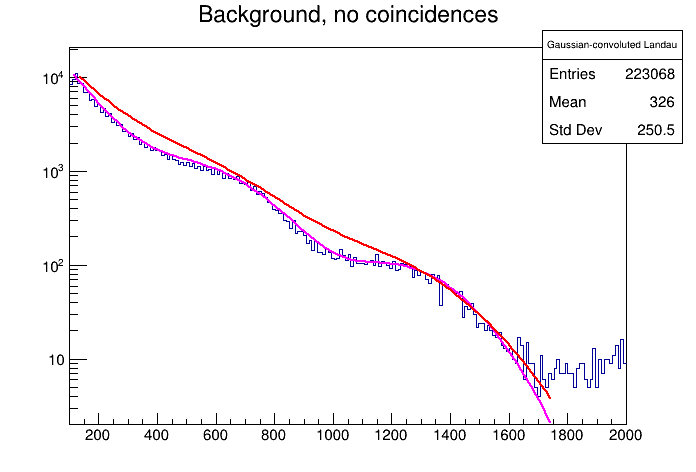

In [133]:
c3 = TCanvas( 'c3', 'Dynamic Filling Example', 200, 10, 700, 500 )
hpx2 = ROOT.TH1D( 'Gaussian-convoluted Landau', 'Background, no coincidences', 200, 100, 2000)
#fill_hist(hpx, np.array(data['data']['low_gain'][:,1]))
fill_hist(hpx2, np.array(data['data']['low_gain']))

hpx2.Draw()
gPad.SetLogy();
total.Draw("same")
tf2.Draw("same")
c3.Draw()

In [116]:
total.GetChisquare()/total.GetNDF()

6.74324651103386

### Calculate integral of function to find number of counts

In [140]:
hpx2.Integral(0,100)

210817.0

### We can now use the muon dE/dx, the ADC/PE and the MPV to get the PE/MeV

In [36]:
muon_dE_dx = 2 #MeV/cm
panelWidth = 2.54 #cm
gainConversionFactor = 11#Check this with Samantha
#Then
pe_per_MeV = gainConversionFactor* MPV * 1/(ADC_to_PE) * 1/(muon_dE_dx*panelWidth)
print("PE/MeV = %0.2f"%pe_per_MeV) #PE/MeV

with open(figure_folder + '/' + 'PEMeV.txt', 'w') as f:
    f.write("PE/MeV = %0.2f"%pe_per_MeV)

PE/MeV = 59.98


NameError: name 'figure_folder' is not defined

## Extra Plots

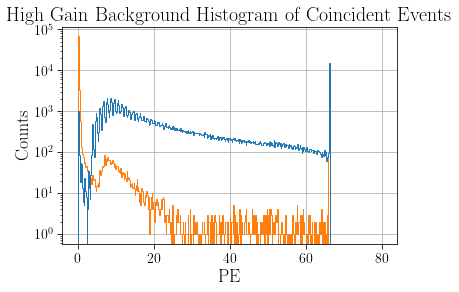

In [32]:
plt.hist((data['data']['high_gain']-ped)/spe, bins=500, range=(0,80),
         histtype='step');
plt.xlabel('~PE')
plt.ylabel('Counts')
plt.grid()
plt.yscale('log');
plt.title('High Gain Background Histogram of Coincident Events')
# Can work on naming scheme
plt.savefig(figure_folder + '/' + 'HighGainPEBackgroundSpectrum_Coincidence.png')

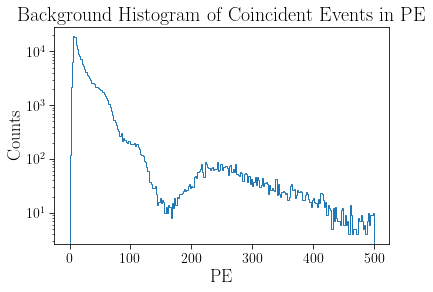

In [33]:
plt.hist((data['data']['low_gain'][:,0]-ped)*rat/spe, bins=250, range=(0,500),
         histtype='step');
plt.yscale('log')
plt.xlabel('~PE')
plt.ylabel('Counts')
plt.title('Background Histogram of Coincident Events in PE')
# Can work on naming scheme
plt.savefig(figure_folder + '/' + 'PEBackgroundSpectrum_CoincidenceOnly.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


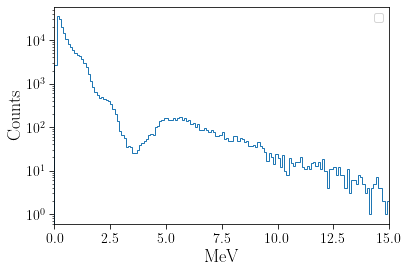

In [34]:
plt.hist((data['data']['low_gain'][:,0]-ped)*rat/spe/pe_per_MeV, bins=150, range=(0,15),
         histtype='step');
plt.xlim(0,15)
#plt.ylim(0,500)
plt.legend()
plt.xlabel('MeV')
plt.ylabel('Counts')
plt.yscale('log')
#histogramData = (data['data']['low_gain'][:,0]-ped)*rat/spe/pe_per_MeV
#np.save("SwirlyPanel24HrRun"+'.npy', histogramData)

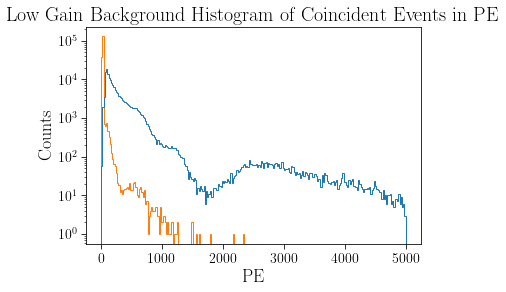

In [35]:
plt.hist((data['data']['low_gain']-ped), bins=250, range=(0,5000),
         histtype='step')
# plt.yscale('log');
# plt.ylim(0,2000);
plt.xlabel('~PE')
plt.yscale('log')
plt.ylabel('Counts')
# plt.vlines(35,0,20000)
plt.title('Low Gain Background Histogram of Coincident Events in PE')
# Can work on naming scheme
plt.savefig(figure_folder + '/' + 'LowGainPEBackgroundSpectrum_Both.png')

In [36]:
mu = (data['data']['low_gain'][:,0]-ped)*rat/spe
len(mu[mu>180])/(data['header']['trigger_ts'][-1]-data['header']['trigger_ts'][0])

9.286652599684512

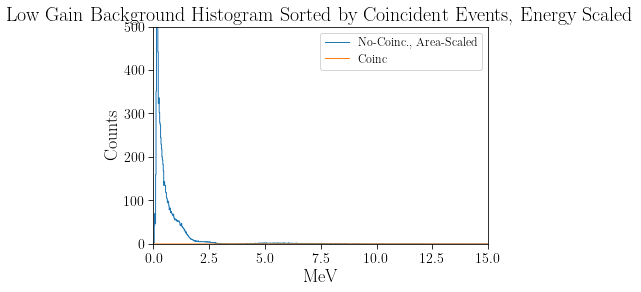

In [37]:
filter = data['data']['low_gain'][:,1] > 2500
d = (data['data']['low_gain'][:,0]-ped)*rat/spe/pe_per_MeV

h1,bins = np.histogram(d, bins=740, range=(0,15))
h2,bins = np.histogram(d[filter], bins=740, range=(0,15))

area_ratio = (6*6)/(25*25)
plt.stairs(h1*area_ratio, bins, label='No-Coinc., Area-Scaled')
plt.stairs(h2, bins, label='Coinc')
plt.xlim(0,15)
plt.ylim(0,500)
plt.legend()
plt.xlabel('MeV')
plt.ylabel('Counts')
plt.vlines(x=265, ymin=0,ymax=5000, linestyles='--', color='k', alpha=0.5)
plt.title('Low Gain Background Histogram Sorted by Coincident Events, Energy Scaled')
# Can work on naming scheme
plt.savefig(figure_folder + '/' + 'PEBackgroundSpectrum_Coincidence.png')

In [49]:
tf1 = ROOT.TF1("landaugausfunction", ROOT.langaufun, 0, 8000, 4)
tf1.SetParNames("LandauWidth","LandauMPV","Normalisation","GaussianSigma")
tf1.SetParameters(func.GetParameter(0), func.GetParameter(1), func.GetParameter(2), func.GetParameter(3))
tf1.Draw()


In [50]:
a = np.arange(10)
b = np.ones(10)

np.where(a>4, a, b)

array([1., 1., 1., 1., 1., 5., 6., 7., 8., 9.])